<a href="https://colab.research.google.com/github/CS4641-2021/sports-numbers-fans/blob/main/FantasyFootballRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall yellowbrick -y

!pip install -U yellowbrick==1.2

Uninstalling yellowbrick-1.2:
  Successfully uninstalled yellowbrick-1.2
  Using cached https://files.pythonhosted.org/packages/1f/ad/ae6744ddb9c7053916bed95430152b9a41b7d410e16a1cc7cd744a611d90/yellowbrick-1.2-py3-none-any.whl


In [2]:
!pip uninstall scikit-learn -y

!pip install -U scikit-learn==0.23.2

Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 6.8MB 3.8MB/s 


In [4]:
from google.colab import files
data = files.upload()

Saving 2020_expert_prediction.csv to 2020_expert_prediction.csv
Saving 2017_efficiency_stats.csv to 2017_efficiency_stats.csv
Saving 2017_advanced_stats.csv to 2017_advanced_stats.csv
Saving 2017_season_stats.csv to 2017_season_stats.csv
Saving 2020_season_redzone.csv to 2020_season_redzone.csv
Saving 2020_season_stats.csv to 2020_season_stats.csv
Saving 2020_game_redzone.csv to 2020_game_redzone.csv
Saving 2020_game_stats.csv to 2020_game_stats.csv
Saving 2020_advanced.csv to 2020_advanced.csv
Saving 2020_efficiency.csv to 2020_efficiency.csv
Saving 2019_season_stats.csv to 2019_season_stats.csv
Saving 2019_game_stats.csv to 2019_game_stats.csv
Saving 2019_season_redzone.csv to 2019_season_redzone.csv
Saving 2019_game_redzone.csv to 2019_game_redzone.csv
Saving 2019_efficiency.csv to 2019_efficiency.csv
Saving 2018_season_stats.csv to 2018_season_stats.csv
Saving 2019_advanced.csv to 2019_advanced.csv
Saving 2018_efficiency.csv to 2018_efficiency.csv
Saving 2018_redzone.csv to 2018_re

In [5]:
import pandas as pd
import yellowbrick
from yellowbrick.features import Rank2D, ParallelCoordinates
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge

In [8]:
#Create dataframe of 2018 stats
df1 = pd.read_csv('2018_season_stats.csv')
df1 = df1.drop(columns="Position")
df2 = pd.read_csv('2018_advanced.csv')
df2 = df2.drop(columns=["Rank","PlayerShortName","Targets","Receptions","ReceivingTDs","ReceivingYards","Targets.1"])
df2 = df2.rename(columns={"PlayerPlayerId" : "PlayerID"})
df3 = pd.read_csv('2018_efficiency.csv')
df3 = df3.drop(columns=["Rank","PlayerShortName","Targets","Receptions","ReceivingTDs","ReceivingYards"])
df3 = df3.rename(columns={"PlayerPlayerId" : "PlayerID"})
df2018 = df1.join(df2.set_index("PlayerID"), on="PlayerID")
df2018 = df2018.join(df3.set_index("PlayerID"), on="PlayerID")

#create dataframe of 2019 stats
df4 = pd.read_csv('2019_season_stats.csv')
df4 = df4.drop(columns="Position")
df5 = pd.read_csv('2019_advanced.csv')
df5 = df5.drop(columns=["Rank","PlayerShortName","Targets","Receptions","ReceivingTDs","ReceivingYards","Targets.1"])
df5 = df5.rename(columns={"PlayerPlayerId" : "PlayerID"})
df6 = pd.read_csv('2019_efficiency.csv')
df6 = df6.drop(columns=["Rank","PlayerShortName","Targets","Receptions","ReceivingTDs","ReceivingYards"])
df6 = df6.rename(columns={"PlayerPlayerId" : "PlayerID"})
df2019 = df4.join(df5.set_index("PlayerID"), on="PlayerID")
df2019 = df2019.join(df6.set_index("PlayerID"), on="PlayerID")

#create dataframe of 2017 stats
df7 = pd.read_csv('2017_season_stats.csv')
df7 = df7.drop(columns="Position")
df8 = pd.read_csv('2017_advanced_stats.csv')
df8 = df8.drop(columns=["Rank","PlayerShortName","Targets","Receptions","ReceivingTDs","ReceivingYards","Targets.1"])
df8 = df8.rename(columns={"PlayerPlayerId" : "PlayerID"})
df9 = pd.read_csv('2017_efficiency_stats.csv')
df9 = df9.drop(columns=["Rank","PlayerShortName","Targets","Receptions","ReceivingTDs","ReceivingYards"])
df9 = df9.rename(columns={"PlayerPlayerId" : "PlayerID"})
df2017 = df7.join(df8.set_index("PlayerID"), on="PlayerID")
df2017 = df2017.join(df9.set_index("PlayerID"), on="PlayerID")

#Create results dataframe for following years
df2018results = df1[["PlayerID","FantasyPointsPPR","FantasyPointsPerGamePPR"]]
df2019results = df4[["PlayerID","FantasyPointsPPR","FantasyPointsPerGamePPR"]]
df2020results = pd.read_csv('2020_season_stats.csv', usecols=["PlayerID","FantasyPointsPPR","FantasyPointsPerGamePPR"])
df2020_expert_prediction = pd.read_csv('2020_expert_prediction.csv', usecols=["PlayerID","FantasyPointsPPR","FantasyPointsPerGamePPR"])


#Adding next year results to season stats
df2017 = df2017.join(df2018results.set_index("PlayerID"), rsuffix="_NextYear", on="PlayerID")
df2018 = df2018.join(df2019results.set_index("PlayerID"), rsuffix="_NextYear", on="PlayerID")
df2019 = df2019.join(df2020results.set_index("PlayerID"), rsuffix="_NextYear", on="PlayerID")


#Removing features that either dont exist for some dataset or are irrelivant, then removing incomplete data 
df2017 = df2017.drop(columns=['Name','Team','AirYards','AirYardsPerGame','AirYardsPerReception', 'TrueCatchRate', 'TargetAccuracy', 'Cushion']).dropna()
df2018 = df2018.drop(columns=['Name','Team','AirYards','AirYardsPerGame','AirYardsPerReception', 'TrueCatchRate', 'TargetAccuracy', 'Cushion']).dropna()
df2019 = df2019.drop(columns=['Name','Team','AirYards','AirYardsPerGame','AirYardsPerReception', 'TrueCatchRate', 'TargetAccuracy', 'Cushion']).dropna()

#Classify scores into some number of bins
num_bins = 4
target_df2017_max = df2017["FantasyPointsPerGamePPR_NextYear"].max()
target_df2017_min = df2017["FantasyPointsPerGamePPR_NextYear"].min()
target_df2017_bin_width = (target_df2017_max - target_df2017_min)/num_bins
df2017["ScoreTier_NextYear"] = -1*((df2017["FantasyPointsPerGamePPR_NextYear"] - target_df2017_min) // (-1*target_df2017_bin_width))
df2017["ScoreTier_NextYear"] = df2017["ScoreTier_NextYear"].replace(0,1)

target_df2018_max = df2018["FantasyPointsPerGamePPR_NextYear"].max()
target_df2018_min = df2018["FantasyPointsPerGamePPR_NextYear"].min()
target_df2018_bin_width = (target_df2018_max - target_df2018_min)/num_bins
df2018["ScoreTier_NextYear"] = -1*((df2018["FantasyPointsPerGamePPR_NextYear"] - target_df2018_min) // (-1*target_df2018_bin_width))
df2018["ScoreTier_NextYear"] = df2018["ScoreTier_NextYear"].replace(0,1)

target_df2019_max = df2019["FantasyPointsPerGamePPR_NextYear"].max()
target_df2019_min = df2019["FantasyPointsPerGamePPR_NextYear"].min()
target_df2019_bin_width = (target_df2019_max - target_df2019_min)/num_bins
df2019["ScoreTier_NextYear"] = -1*((df2019["FantasyPointsPerGamePPR_NextYear"] - target_df2019_min) // (-1*target_df2019_bin_width))
df2019["ScoreTier_NextYear"] = df2019["ScoreTier_NextYear"].replace(0,1)

df1718 = pd.concat([df2017,df2018],ignore_index=True)

#Get expert predictions for players that are in our testing data and sort predictions by playerID
expert_prediction = df2020_expert_prediction[df2020_expert_prediction["PlayerID"].isin(df2019["PlayerID"])].sort_values(by=['PlayerID'])
expert_prediction.reset_index(inplace=True, drop=True)



In [9]:
def normalizeDF(df, exclude_columns=[]):
  result = df.copy()
  for feature_name in df.columns:
    if feature_name in exclude_columns:
      continue
    max_value = df[feature_name].max()
    min_value = df[feature_name].min()
    result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
  return result

def normalizeSeries(series):
  result = series.copy()
  max_value = series.max()
  min_value = series.min()
  result = (series - min_value) / (max_value - min_value)
  return result

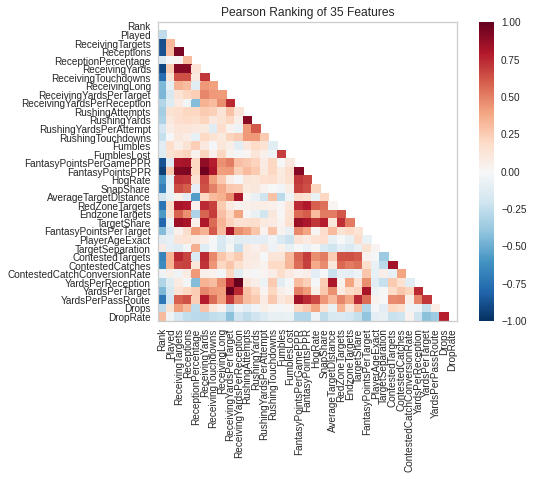

In [10]:
visualizer = Rank2D(algorithm = "pearson")
visualizer.fit_transform(normalizeDF(df2018.drop(["PlayerID", "FantasyPointsPPR_NextYear", "FantasyPointsPerGamePPR_NextYear", "ScoreTier_NextYear"],axis=1)))
visualizer.show()


Parallel Coordinates

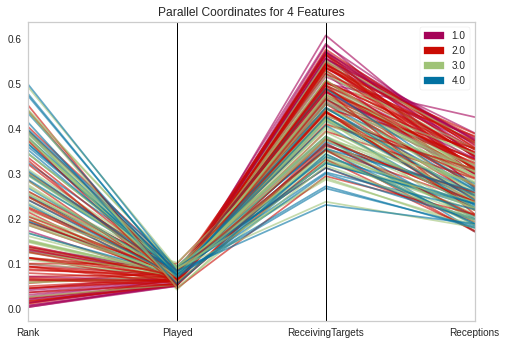

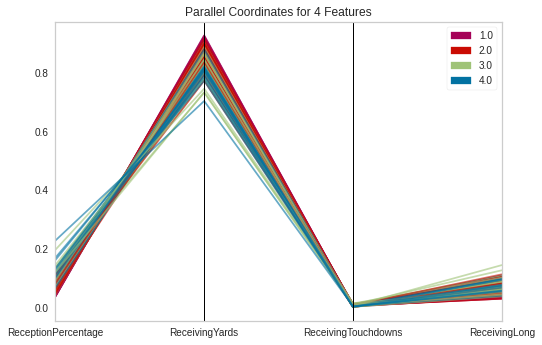

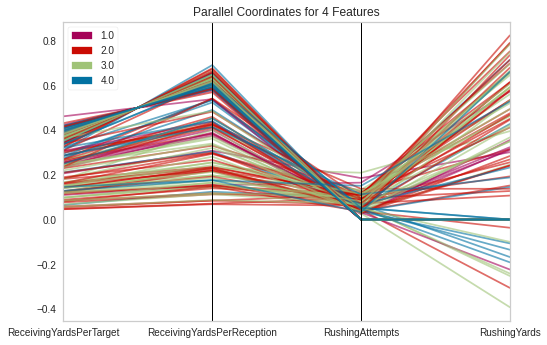

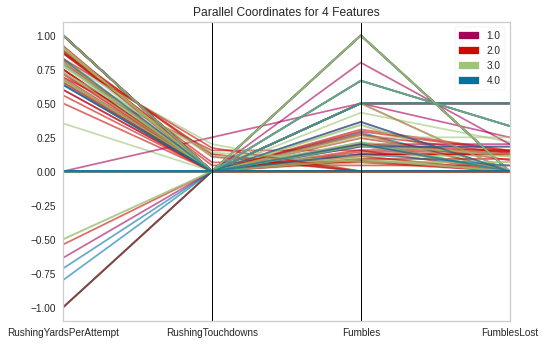

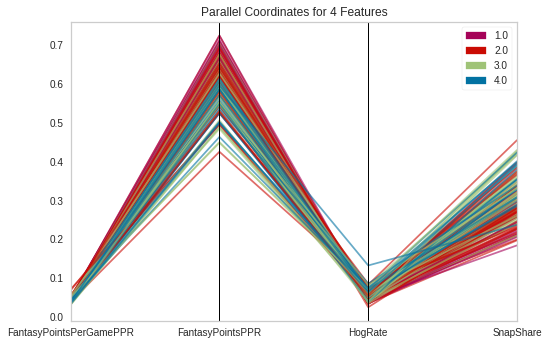

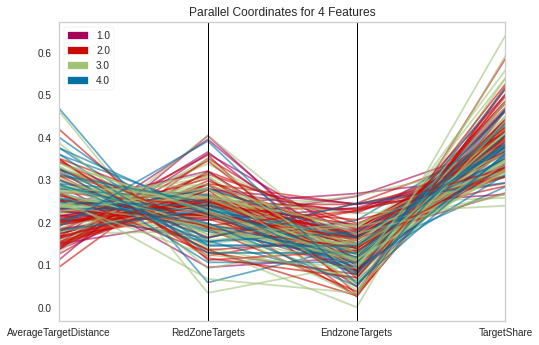

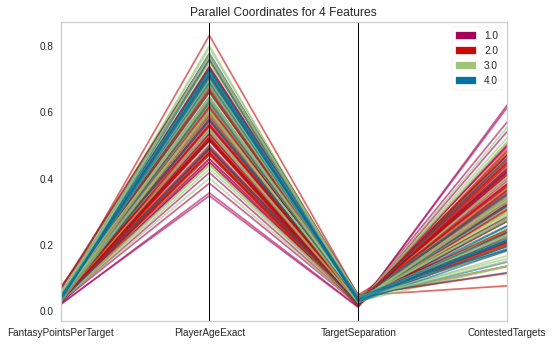

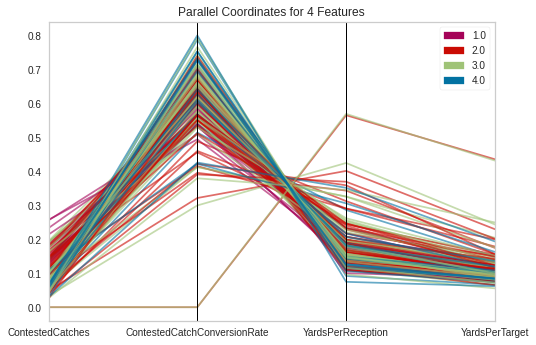

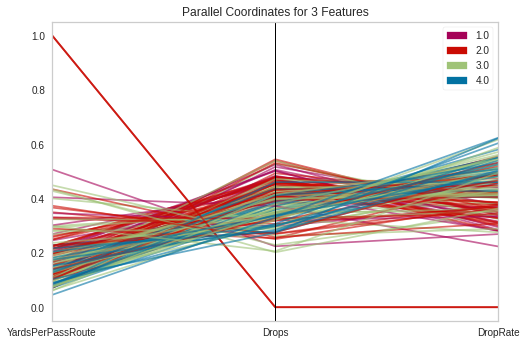

In [11]:
features = df1718.drop(columns=["FantasyPointsPPR_NextYear", "ScoreTier_NextYear", "PlayerID", "FantasyPointsPerGamePPR_NextYear"]).columns
classes = df1718["ScoreTier_NextYear"].unique()
#splitting the classes into bite size chunks to make visualization easier
split_features = np.array_split(features, 9)
for feature_set in split_features:
  visualizer = visualizer = ParallelCoordinates(
      classes=classes, features=feature_set,
      normalize='l1', alpha=.6
  )
  visualizer.fit(df1718[feature_set], df1718["ScoreTier_NextYear"])     
  visualizer.transform(df1718[feature_set])   
  visualizer.poof()

Distribution of target variable

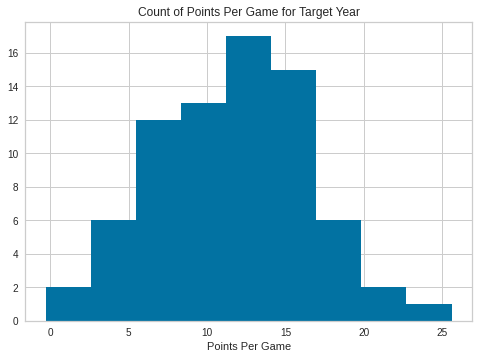

In [12]:
results = df2019["FantasyPointsPerGamePPR_NextYear"]
_ = plt.hist(results, bins='auto')
plt.title("Count of Points Per Game for Target Year")
plt.xlabel("Points Per Game")
plt.show()


Model Predictions

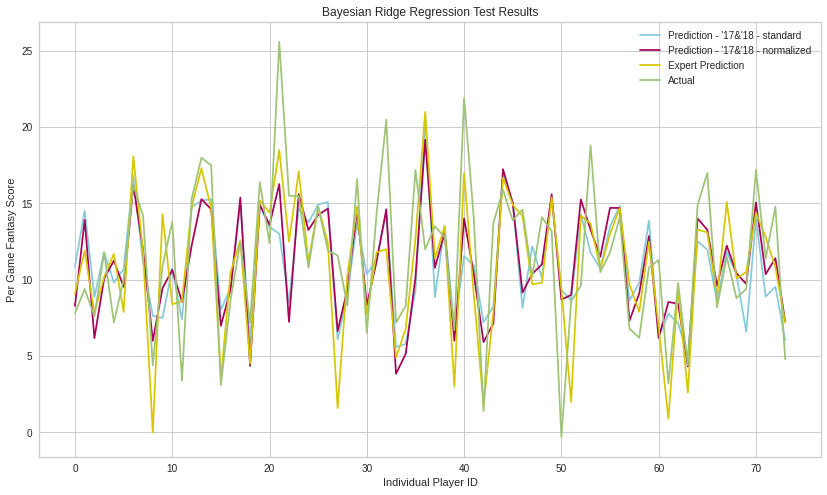

In [14]:
#Non normalized training set
train_x_1 = df1718.drop(columns=["FantasyPointsPerGamePPR_NextYear","FantasyPointsPPR_NextYear","PlayerID", "ScoreTier_NextYear"])
train_y_1 = df1718["FantasyPointsPerGamePPR_NextYear"]

#Normalized training set
train_x_2 = normalizeDF(df1718.drop(columns=["FantasyPointsPerGamePPR_NextYear","FantasyPointsPPR_NextYear","PlayerID", "ScoreTier_NextYear"]))
train_y_2 = df1718["FantasyPointsPerGamePPR_NextYear"]

#Create the testing set, which is sorted by playerID containing the same elements as expert_prediction, in order 
#Testing data sorted by playerID (actual data does not contain the playerID, though)
test_x_1 = df2019.sort_values(by=["PlayerID"]).drop(columns=["FantasyPointsPerGamePPR_NextYear","FantasyPointsPPR_NextYear","PlayerID", "ScoreTier_NextYear"])
test_x_2 = normalizeDF(test_x_1)
test_y = df2019.sort_values(by=["PlayerID"])["FantasyPointsPerGamePPR_NextYear"]

test_x_1.reset_index(inplace=True, drop=True)
test_x_2.reset_index(inplace=True, drop=True)
test_y.reset_index(inplace=True, drop=True)



#Normal ridge regression
clf = BayesianRidge()
clf.fit(train_x_1, train_y_1)
p_1 = clf.predict(test_x_1)
clf.fit(train_x_2, train_y_2)
p_2 = clf.predict(test_x_2)


plt.figure(figsize=(14,8))
#plt.plot(test_x.index, df2019.sort_values(by=["PlayerID"])["FantasyPointsPerGamePPR"], 'C6', label='Last Year Performance') 
plt.plot(test_x_1.index, p_1, 'C5', label='Prediction - \'17&\'18 - standard') 
plt.plot(test_x_1.index, p_2, 'C3', label='Prediction - \'17&\'18 - normalized') 
plt.plot(test_x_1.index, expert_prediction["FantasyPointsPerGamePPR"], 'C4', label='Expert Prediction') 
plt.plot(test_x_1.index, test_y, 'C1', label="Actual")


plt.xlabel("Individual Player ID")
plt.ylabel("Per Game Fantasy Score")
plt.title("Bayesian Ridge Regression Test Results")
plt.legend()

Calculate RMSE for BayseanRidge

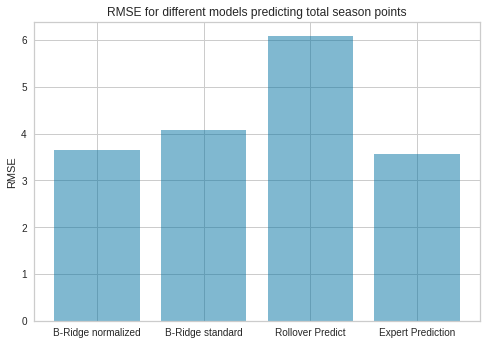

3.637516088818239
4.074127210906558
6.0813447216210665
3.558696998105391


In [15]:
models = ["B-Ridge normalized", "B-Ridge standard", "Rollover Predict", 'Expert Prediction']
pos = np.arange(len(models))
performance = np.zeros(len(models))
performance[0] = np.sqrt(np.mean((p_2-test_y)**2))
performance[1] = np.sqrt(np.mean((p_1-test_y)**2))
performance[2] = np.sqrt(np.mean(((df2019.sort_values(by=["PlayerID"])["FantasyPointsPerGamePPR"])-test_y)**2))
performance[3] = np.sqrt(np.mean((expert_prediction['FantasyPointsPerGamePPR']-test_y)**2))

plt.bar(pos, performance, align='center', alpha=0.5)
plt.xticks(pos, models)
plt.ylabel('RMSE')
plt.title('RMSE for different models predicting total season points')
plt.show()

print(performance[0])
print(performance[1])
print(performance[2])
print(performance[3])

#Linear Regression



In [16]:
from yellowbrick.regressor import ResidualsPlot
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split






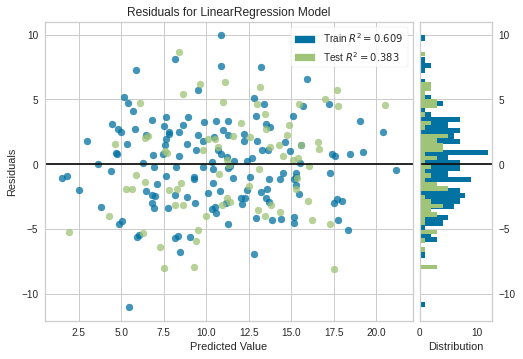

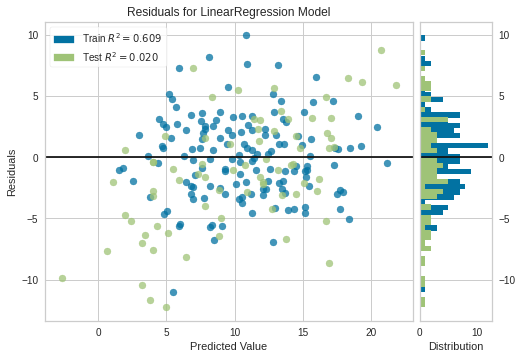

In [18]:
# Create training and test sets
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.1
#)
## df1718 dataset
visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(train_x_1, train_y_1)
visualizer.score(test_x_1, test_y)
visualizer.show()

##df2019 dataset
visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(train_x_2, train_y_2)
visualizer.score(test_x_2, test_y)
visualizer.show()


# KMeans Clustering
From https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a


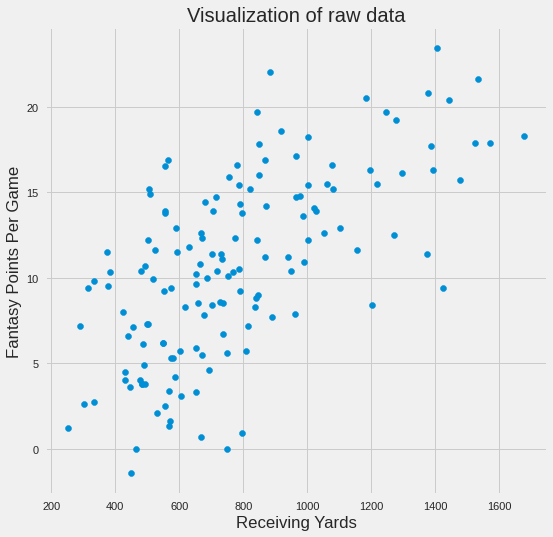

In [65]:
# Plot the raw data df1718
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import seaborn as sns
from sklearn.datasets.samples_generator import (make_blobs,
                                                make_circles,
                                                make_moons)
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

%matplotlib inline
sns.set_context('notebook')
plt.style.use('fivethirtyeight')
from warnings import filterwarnings
filterwarnings('ignore')

# Import the data
#df1718.head()
df = df1718[['ReceivingYards', 'FantasyPointsPerGamePPR_NextYear']]
#df.head()
#df1718.iloc[:,6]
#df1718.iloc[:,-2]
# Plot the data
plt.figure(figsize=(8, 8))
#plt.scatter(df1718.iloc[:, 6], df1718.iloc[:, -2])
plt.scatter(df.iloc[:,0], df.iloc[:,1])
plt.xlabel('Receiving Yards')
plt.ylabel('Fantasy Points Per Game')
plt.title('Visualization of raw data');

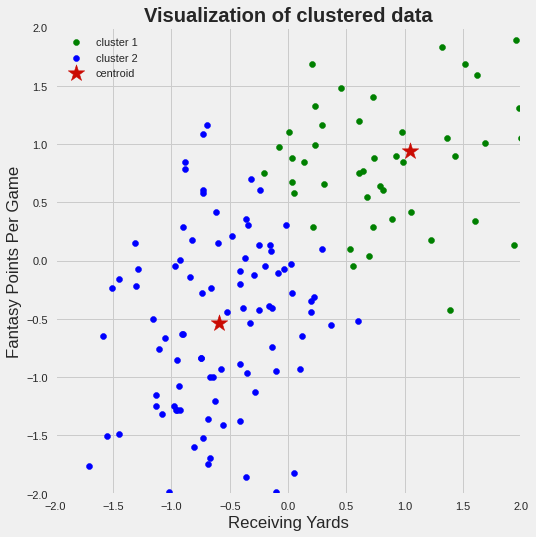

In [66]:
# Standardize the data
X_std = StandardScaler().fit_transform(df)

# Run local implementation of kmeans
km = KMeans(n_clusters=2, max_iter=100)
km.fit(X_std)
centroids = km.cluster_centers_

# Plot the clustered data
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(X_std[km.labels_ == 0, 0], X_std[km.labels_ == 0, 1],
            c='green', label='cluster 1')
plt.scatter(X_std[km.labels_ == 1, 0], X_std[km.labels_ == 1, 1],
            c='blue', label='cluster 2')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300,
            c='r', label='centroid')
plt.legend()
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('Receiving Yards')
plt.ylabel('Fantasy Points Per Game')
plt.title('Visualization of clustered data', fontweight='bold')
ax.set_aspect('equal');

Elbow Method

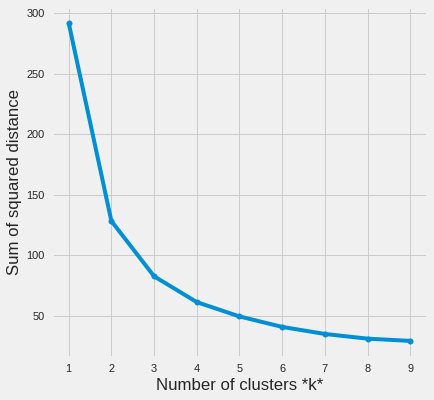

In [67]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_std)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

Silhouette Analysis


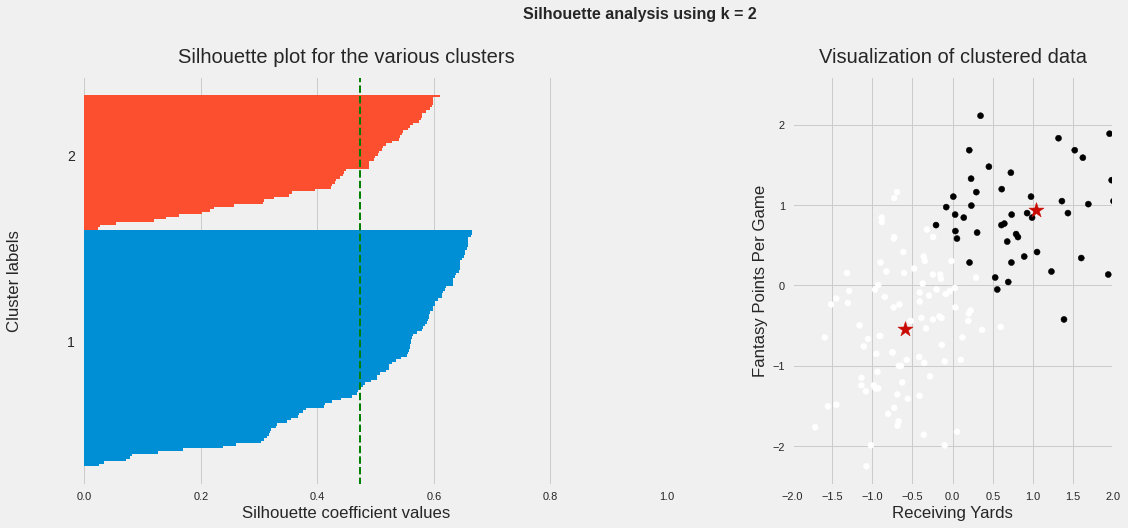

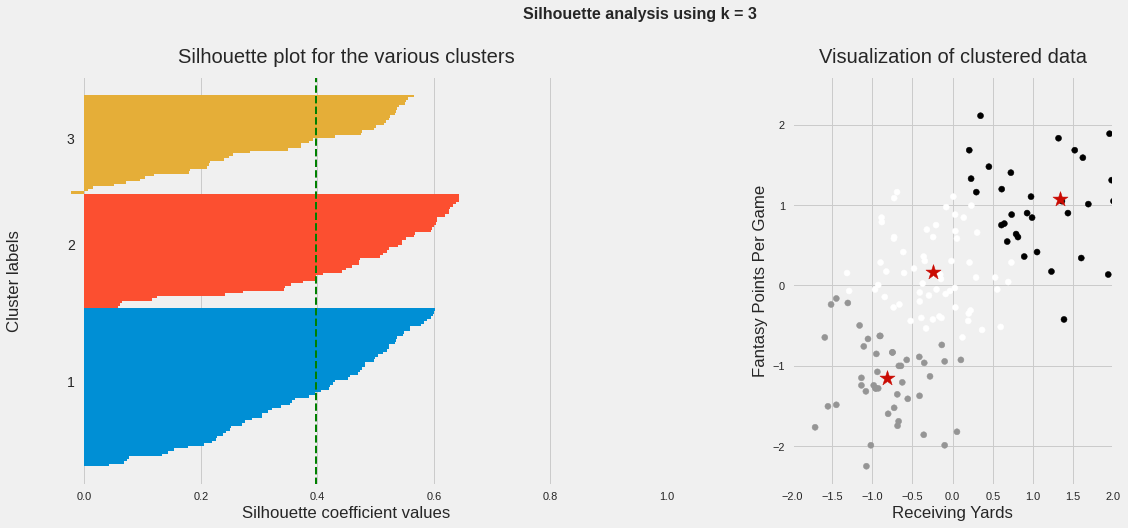

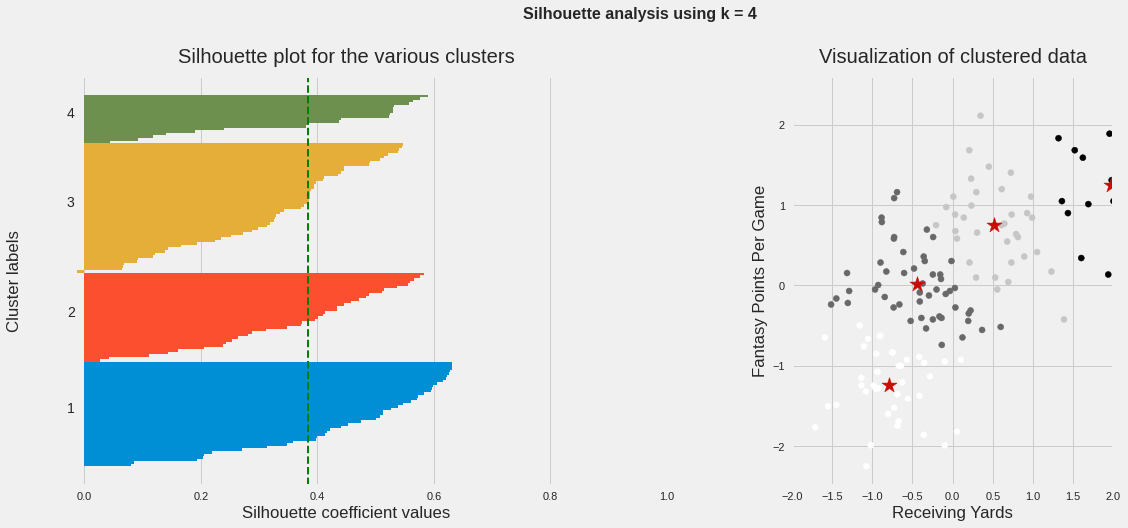

In [69]:
for i, k in enumerate([2, 3, 4]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X_std)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X_std, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(X_std[:, 0], X_std[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('Receiving Yards')
    ax2.set_ylabel('Fantasy Points Per Game')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);